In [1]:
#!pip install wordcloud nltk

# 1. Obtención de datos

In [2]:
'''import requests

url = 'https://mcauleylab.ucsd.edu/public_datasets/data/amazon_2023/raw/review_categories/Books.jsonl.gz'
output_path = "/Users/santiagojorda/Desktop/Desktop - Santiago’s MacBook Pro/Personal/KeepCoding/NLP/NLP_03 copy/Project/Notebooks/Books.jsonl"
response = requests.get(url)
with open(output_path, 'wb') as f:
    f.write(response.content)

print(f"CSV descargado en: {output_path}")'''

'import requests\n\nurl = \'https://mcauleylab.ucsd.edu/public_datasets/data/amazon_2023/raw/review_categories/Books.jsonl.gz\'\noutput_path = "/Users/santiagojorda/Desktop/Desktop - Santiago’s MacBook Pro/Personal/KeepCoding/NLP/NLP_03 copy/Project/Notebooks/Books.jsonl"\nresponse = requests.get(url)\nwith open(output_path, \'wb\') as f:\n    f.write(response.content)\n\nprint(f"CSV descargado en: {output_path}")'

In [3]:
import json
import pandas as pd
from collections import defaultdict

def get_balanced_reviews(jsonl_path, samples_per_rating=800, total_samples=4000):
    """
    Lee un archivo JSONL con reseñas y extrae un número equilibrado de muestras para cada rating.
    
    Args:
        jsonl_path: Ruta al archivo JSONL
        samples_per_rating: Número de muestras a extraer por cada valor de rating
        total_samples: Número total de muestras deseadas
    
    Returns:
        DataFrame de pandas con las reseñas balanceadas
    """
    # Diccionario para almacenar reseñas por rating
    reviews_by_rating = defaultdict(list)
    
    # Contador para llevar registro de cuántas reseñas tenemos por cada rating
    counts = defaultdict(int)
    
    # El número de ratings diferentes (1-5)
    num_ratings = 5
    
    print(f"Leyendo archivo JSONL y seleccionando {samples_per_rating} reseñas por cada rating...")
    
    # Leer el archivo línea por línea
    with open(jsonl_path, 'r', encoding='utf-8') as file:
        for line in file:
            if not line.strip():
                continue
                
            # Parsear la línea JSON
            try:
                review = json.loads(line)
                rating = review.get('rating')
                
                # Solo considerar ratings válidos (1-5)
                if rating not in [1.0, 2.0, 3.0, 4.0, 5.0]:
                    continue
                
                # Si todavía necesitamos más reseñas de este rating
                if counts[rating] < samples_per_rating:
                    reviews_by_rating[rating].append(review)
                    counts[rating] += 1
                
                # Verificar si ya tenemos suficientes reseñas de cada rating
                if all(counts[r] >= samples_per_rating for r in [1.0, 2.0, 3.0, 4.0, 5.0]):
                    print("¡Se ha completado la recolección equilibrada de reseñas!")
                    break
                    
            except json.JSONDecodeError:
                print("Error al decodificar una línea JSON. Continuando...")
    
    # Combinar todas las reseñas en una lista
    all_reviews = []
    for rating in [1.0, 2.0, 3.0, 4.0, 5.0]:
        all_reviews.extend(reviews_by_rating[rating])
        print(f"Rating {rating}: {len(reviews_by_rating[rating])} reseñas recopiladas")
    
    # Convertir a DataFrame
    df = pd.DataFrame(all_reviews)
    
    return df


Para facilitar la tarea seleccionamos 800 reseñas por cada rating (1-5) para un total de 4000 reseñas para conseguir un dataframe totalmente balanceado

In [4]:
file_path = "Books.jsonl"

try:
    # Obtener 800 reseñas por cada rating (1-5)
    reviews_df = get_balanced_reviews(file_path)
    
    print(f"Total de reseñas recopiladas: {len(reviews_df)}")
    print("\nDistribución de ratings:")
    print(reviews_df['rating'].value_counts().sort_index())
    
    # Guardar el dataframe a un archivo CSV (opcional)
    reviews_df.to_csv("reviews_equilibradas.csv", index=False)
    print("\nDataframe guardado como 'reviews_equilibradas.csv'")
    
except FileNotFoundError:
    print(f"Error: El archivo {file_path} no se encontró")
except Exception as e:
    print(f"Error inesperado: {e}")

Leyendo archivo JSONL y seleccionando 800 reseñas por cada rating...
¡Se ha completado la recolección equilibrada de reseñas!
Rating 1.0: 800 reseñas recopiladas
Rating 2.0: 800 reseñas recopiladas
Rating 3.0: 800 reseñas recopiladas
Rating 4.0: 800 reseñas recopiladas
Rating 5.0: 800 reseñas recopiladas
Total de reseñas recopiladas: 4000

Distribución de ratings:
rating
1.0    800
2.0    800
3.0    800
4.0    800
5.0    800
Name: count, dtype: int64

Dataframe guardado como 'reviews_equilibradas.csv'


# 2. Exploración de datos

In [5]:
columnas_lista = reviews_df.columns.tolist()
print(columnas_lista)

['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']


In [6]:
reviews_df.head(1)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,1.0,Not a watercolor book! Seems like copies imo.,It is definitely not a watercolor book. The p...,[{'small_image_url': 'https://m.media-amazon.c...,B09BGPFTDB,B09BGPFTDB,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1642399598485,0,True


Seleccionamos unicamente las comlumnas **rating** y **text**

In [7]:
reviews_df = reviews_df.loc[ : ,['rating', 'text']].copy()

In [8]:
reviews_df.head()

,rating,text
0,1.0,It is definitely not a watercolor book. The p...
1,1.0,Missing the sketch pad. Even worse I realized ...
2,1.0,Every page has a crease running the entire len...
3,1.0,Only read and believe things you want to see c...
4,1.0,My little one just likes doctors so I thought ...


### Justificación para la Transformación a Clasificación Binaria en Análisis de Sentimiento 
 
Transformar el análisis de sentimiento a una clasificación binaria tiene mucho sentido en contextos reales, donde lo importante es distinguir si una experiencia fue positiva o negativa, más que matizar entre cinco niveles. En la práctica, valoraciones intermedias como las de 3 estrellas tienden a generar ruido, ya que suelen ser ambiguas y difíciles de interpretar tanto para el modelo como para los usuarios. Además, esta simplificación mejora notablemente el rendimiento de los modelos, como BERT o LSTM, que funcionan mejor cuando el problema está claramente definido. Muchas plataformas como Amazon ya aplican este enfoque porque facilita recomendaciones, mejora la interpretabilidad de los resultados y permite actuar más rápidamente ante reseñas negativas. En definitiva, es una elección que combina utilidad práctica con eficacia técnica.

In [9]:
reviews_df['rating_binario'] = reviews_df['rating'].map(lambda x: 1 if x >= 4.0 else 0)

In [10]:
reviews_df['rating_binario'].unique()

array([0, 1])

In [11]:
pd.set_option('display.max_colwidth', None)

In [12]:
reviews_df[['text']].head(10)

,text
0,"It is definitely not a watercolor book. The paper bucked completely. The pages honestly appear to be photo copies of other pictures. I say that bc if you look at the seal pics you can see the tell tale line at the bottom of the page. As someone who has made many photocopies of pages in my time so I could try out different colors & mediums that black line is a dead giveaway to me. It’s on other pages too. The entire book just seems off. Nothing is sharp & clear. There is what looks like toner dust on all the pages making them look muddy. There are no sharp lines & there is no clear definition. At least there isn’t in my copy. And the Coloring Book for Adult on the bottom of the front cover annoys me. Why is it singular & not plural? They usually say coloring book for kids or coloring book for kids & adults or coloring book for adults- plural. Lol Plus it would work for kids if you can get over the grey scale nature of it. Personally I’m not going to waste expensive pens & paints trying to paint over the grey & black mess. I grew up in SW Florida minutes from the beaches & I was really excited about the sea life in this. I hope the printers & designers figure out how to clean up the mess bc some of the designs are really cute. They just aren’t worth my time to hand trace & transfer them, but I’m sure there are ppl that will be up to the challenge. This is one is a hard no. Going back. I tried."
1,Missing the sketch pad. Even worse I realized it’s identical to the Drawing Lab For Mixed Media Artists book I already bought.
2,Every page has a crease running the entire length of the book about an inch and a half from the edges.
3,"Only read and believe things you want to see come true. Focus your attention on stories that uplift and inspire a greater future. The author meant well, but has his own journey and beliefs to conquer to see clearly."
4,My little one just likes doctors so I thought this book would be fun but it’s not what I expected. It’s more about helping if your little one is scared of going to the doctor. There is only one picture of the doctor in the book.
5,Nothing new for a collector of Antique Jewellery! Pretty much all the pieces on this book have been in other Jewelry books!!! And the funny/annoying thing no prices of the auction prices are listed either.<br /><br />Sad to say I was really disappointed with it. Buy a used copy if you really want it!
6,This is not what I thought it was. All of the questions are way too close together - the book is not meant to be written in. I wanted a book my loved ones could fill out the answers to the questions in. This is just a huge list of questions. Way more questions than anyone would ever want to answer.
7,I got the book but cd is missing! !!
8,"This book is dumb, maybe worth $0.50 certainly not $2.00 you could easily find this in a dollar store and prob even better, there are 4 cupcake pictures and a few stickers.. not sure what I was expecting but this was definitely a disappointment"
9,Hard to get through was very disappointed with this book it was as if it was written by a fan with a crush on Anita.


In [13]:
!pip install html5lib

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import re 
import unicodedata
nltk.download('all')
    

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/santiagojorda/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/santiagojorda/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/santiagojorda/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /Users/santiagojorda/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/santiagojorda/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagg

True

In [15]:
def eda_text_column(df, text_column='text', top_n=20):
    """
    Realiza un EDA de una columna de texto, mostrando:
    - Tamaño del vocabulario
    - Número medio de palabras por review
    - Distribución del tamaño de las reviews
    - Palabras más frecuentes
    - Bigrams más frecuentes
    - Trigrams más frecuentes
    - Nube de palabras
    
    Parámetros:
    - df: DataFrame de pandas.
    - text_column: Nombre de la columna de texto (default: 'text').
    - top_n: Número de elementos a mostrar en frecuencias (default: 20).
    """
    # Configuración inicial
    try:
        plt.style.use('seaborn-v0_8')  # Para versiones recientes de matplotlib
    except:
        plt.style.use('ggplot')  # Estilo alternativo si seaborn no está disponible
    
    plt.rcParams['figure.figsize'] = (12, 6)
    
    # 0. Limpieza inicial: eliminar etiquetas HTML
    df[text_column] = df[text_column].astype(str).apply(lambda x: re.sub(r'<br\s*/?>', ' ', x))
    
    # 1. Calcular estadísticas de longitud
    stop_words = set(stopwords.words('english'))
    df['word_count'] = df[text_column].apply(
        lambda x: len([word for word in word_tokenize(x.lower()) 
                      if word.isalpha() and word not in stop_words]))
    
    mean_words = df['word_count'].mean()
    median_words = df['word_count'].median()
    
    print(f"Estadísticas de longitud:")
    print(f"- Media de palabras por review: {mean_words:.1f}")
    print(f"- Mediana de palabras por review: {median_words:.1f}")
    print(f"- Reviews analizadas: {len(df)}")
    
    # 2. Gráfico de distribución de longitudes
    plt.figure(figsize=(12, 6))
    sns.histplot(df['word_count'], bins=30, kde=True, color='skyblue')
    plt.axvline(mean_words, color='red', linestyle='--', label=f'Media: {mean_words:.1f}')
    plt.axvline(median_words, color='green', linestyle=':', label=f'Mediana: {median_words:.1f}')
    plt.title('Distribución del tamaño de las reviews (palabras por review)')
    plt.xlabel('Número de palabras')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.show()
    
    # 3. Preprocesamiento para análisis de frecuencias
    text = ' '.join(df[text_column].str.lower())
    words = word_tokenize(text)
    words = [word for word in words if word.isalpha() and word not in stop_words]
    
    # 4. Tamaño del vocabulario
    vocab_size = len(set(words))
    print(f"\nAnálisis léxico:")
    print(f"- Vocabulario único: {vocab_size} palabras")
    
    # 5. Palabras más frecuentes
    word_freq = Counter(words)
    top_words = word_freq.most_common(top_n)
    
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    sns.barplot(x=[count for word, count in top_words], y=[word for word, count in top_words])
    plt.title(f'Top {top_n} palabras más frecuentes')
    
    # 6. Bigrams más frecuentes
    bigrams = list(ngrams(words, 2))
    bigram_freq = Counter(bigrams)
    top_bigrams = bigram_freq.most_common(top_n)
    
    plt.subplot(2, 2, 2)
    sns.barplot(x=[count for bigram, count in top_bigrams], 
                y=[' '.join(bigram) for bigram, count in top_bigrams])
    plt.title(f'Top {top_n} bigrams más frecuentes')
    
    # 7. Trigrams más frecuentes
    trigrams = list(ngrams(words, 3))
    trigram_freq = Counter(trigrams)
    top_trigrams = trigram_freq.most_common(top_n)
    
    plt.subplot(2, 2, 3)
    sns.barplot(x=[count for trigram, count in top_trigrams], 
                y=[' '.join(trigram) for trigram, count in top_trigrams])
    plt.title(f'Top {top_n} trigrams más frecuentes')
    
    plt.tight_layout()
    plt.show()
    
    # 8. Nube de palabras
    print("\nNube de palabras representativa:")
    wordcloud = WordCloud(width=800, height=400, 
                         background_color='white',
                         colormap='viridis').generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Nube de palabras (términos más frecuentes)')
    plt.show()


Estadísticas de longitud:
- Media de palabras por review: 87.1
- Mediana de palabras por review: 45.0
- Reviews analizadas: 4000


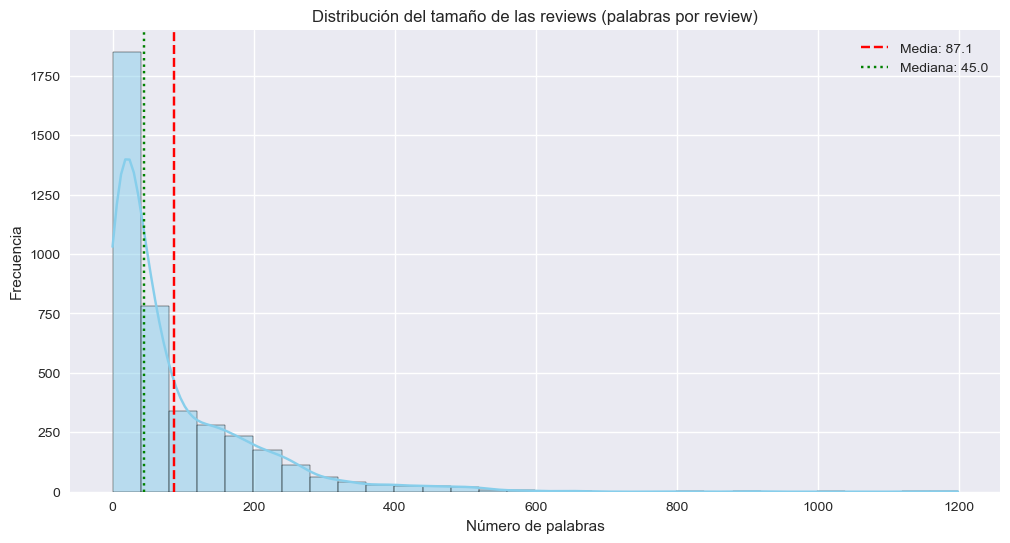


Análisis léxico:
- Vocabulario único: 29773 palabras


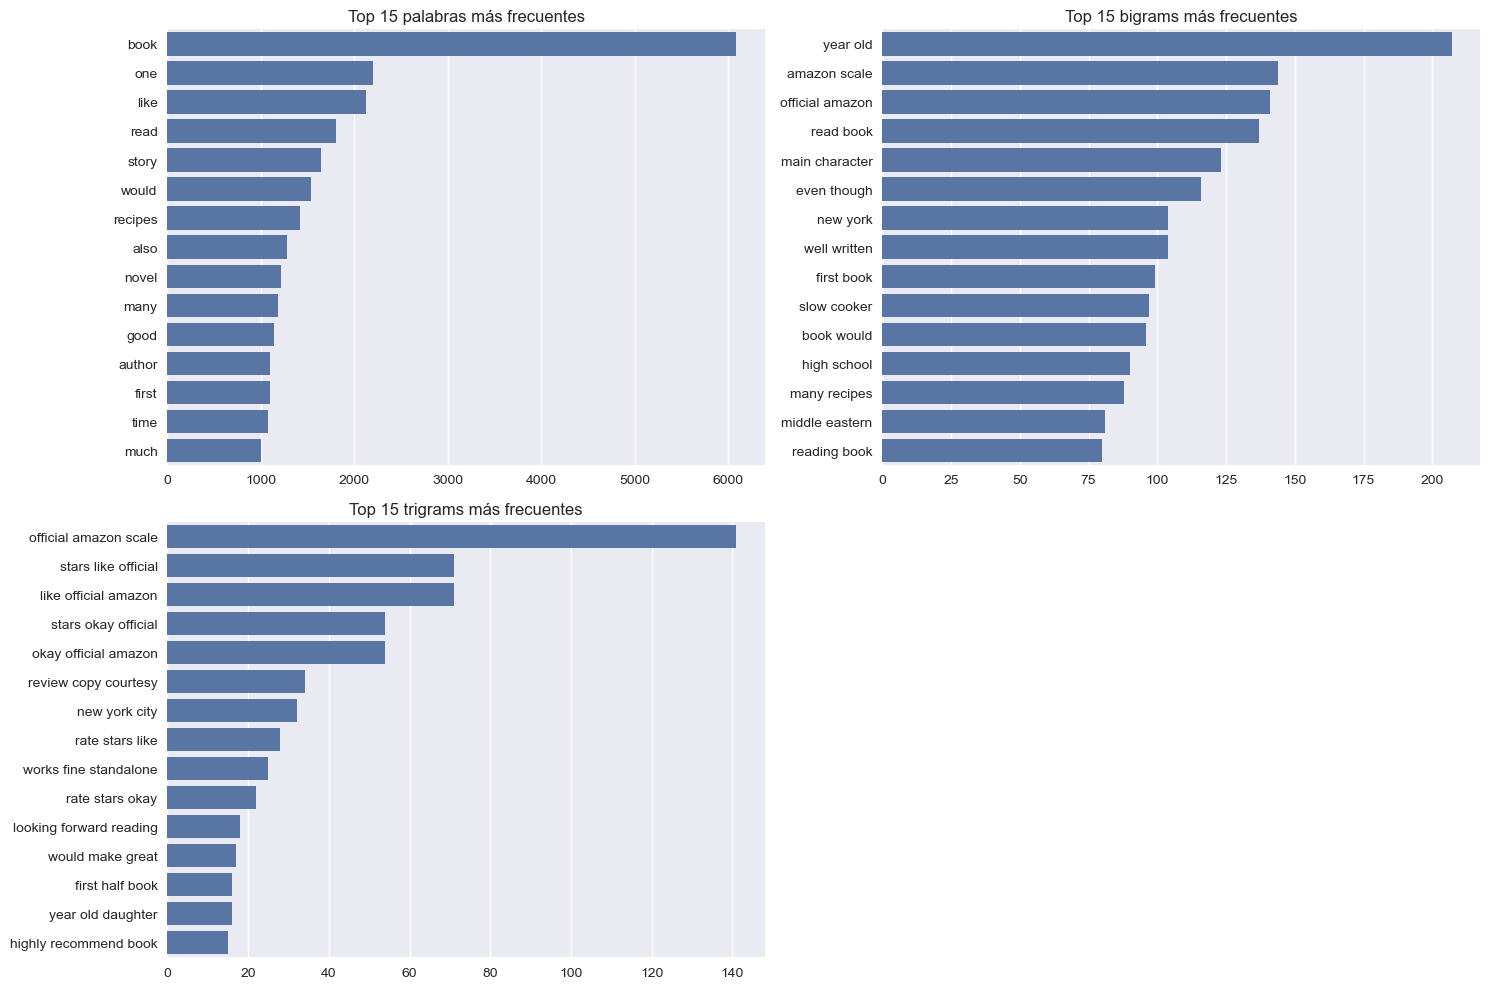


Nube de palabras representativa:


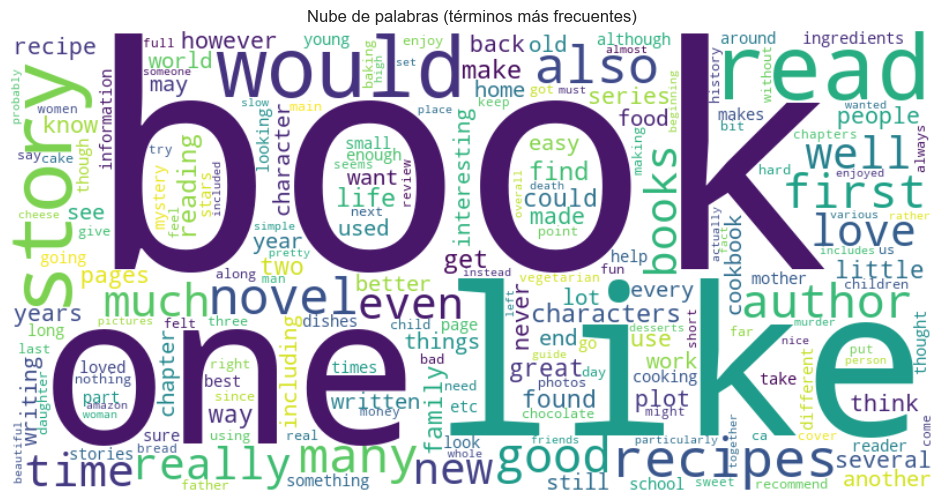

In [16]:
eda_text_column(reviews_df, text_column='text', top_n=15)

# 4. Preprocesamiento

### Justificación del tratamiento de palabras en el preprocesamiento de texto

En el contexto del análisis de sentimiento, he tomado decisiones específicas respecto al tratamiento de ciertas palabras funcionales, considerando su impacto en la interpretación semántica de las oraciones.

En primer lugar, **he decidido conservar las palabras de negación** como *"not"*, *"no"*, *"never"*, entre otras, ya que son elementos clave que pueden **invertir completamente el sentimiento** de una expresión. Por ejemplo, la frase *"I am happy"* tiene una carga positiva, mientras que *"I am not happy"* representa un sentimiento claramente negativo. Eliminar estas palabras podría llevar al modelo a interpretar erróneamente el sentimiento del texto.

Por otro lado, he optado por **eliminar intensificadores** como *"very"*, *"too"*, *"quite"* o *"extremely"*. Aunque estos modificadores amplifican la intensidad del sentimiento, en muchos casos introducen variabilidad superficial sin cambiar el sentido general de la polaridad (positivo o negativo). Además, su frecuencia y subjetividad pueden introducir ruido que afecte la generalización del modelo.

Finalmente, también he decidido **eliminar conectores de contraste** como *"but"*, *"however"* y *"although"*. Si bien estos elementos pueden marcar un cambio de orientación en el discurso, su valor semántico aislado es ambiguo, y su interpretación adecuada depende del contexto completo de la oración. Al eliminarlos, simplifico el espacio semántico del texto y evito complicaciones sintácticas que podrían requerir modelos más avanzados de análisis estructural.

In [17]:
# Lista de stopwords en inglés a eliminar (conservando negaciones)
stop_words = set(stopwords.words('english'))
palabras_conservar = {"no", "not", "never", "barely", "hardly", "neither", 
                      "nor", "very", "too", "quite", "extremely", "really",
                      "so", "much" "more", "most", "less", "least", "better", "best", "worse", "worst",
                      "but", "however", "although", "despite", "yet", "still", "while"
                      }
stop_words = [word for word in stop_words if word not in palabras_conservar]

In [18]:
# Función para eliminar tildes
def eliminar_tildes(texto):
    texto = unicodedata.normalize('NFKD', texto).encode('ASCII', 'ignore').decode('utf-8')
    return texto

### Justificación del uso de lematización frente a stemming en análisis de sentimiento

En este proyecto de análisis de sentimiento, he preferido aplicar **lematización** en lugar de usar un **stemmer**, principalmente porque la lematización conserva mejor el significado real de las palabras, lo cual es clave cuando lo que se intenta capturar es el tono o la carga emocional de un texto.

El **stemming** funciona cortando sufijos o terminaciones para reducir una palabra a su raíz, pero muchas veces esto genera formas que no existen y que pueden perder el sentido original. Por ejemplo, tanto *"happy"* como *"happiness"* podrían quedar como *"happi"*, lo cual no ayuda mucho si lo que queremos es entender el sentimiento.

En cambio, la **lematización** convierte las palabras en su forma base real (*lemma*), teniendo en cuenta su función gramatical. Así, *"was"*, *"are"* y *"being"* pasan a ser *"be"*, y *"better"* se transforma en *"good"*. Esto hace que el texto conserve su sentido general, pero con menos variabilidad innecesaria.

En el contexto del análisis de sentimiento, donde una sola palabra puede cambiar totalmente el tono de una frase, este tipo de limpieza más fina ayuda a que el modelo aprenda mejor los patrones y no se pierda por diferencias superficiales.

En resumen, la lematización me parece una opción más fiable que el stemming cuando se busca interpretar correctamente el contenido emocional del texto.

In [19]:
# Función de limpieza para cada texto
def limpiar_texto(texto):
    # Eliminar etiquetas HTML
    texto = BeautifulSoup(texto, "html.parser").get_text()
    
    # Normalizar a minúsculas
    texto = texto.lower()
    
    # Eliminar tildes
    texto = eliminar_tildes(texto)
    
    # Eliminar símbolos y caracteres no alfabéticos
    texto = re.sub(r'[^a-zA-Z\s]', ' ', texto)
    
    # Tokenizar y eliminar stopwords (conservando negaciones)
    palabras = word_tokenize(texto)
    palabras = [palabra for palabra in palabras if palabra not in stop_words]

    # Lematización
    lemmatizer = WordNetLemmatizer()
    # Primer paso: lematizar como verbos
    palabras = [lemmatizer.lemmatize(palabra, pos='v') for palabra in palabras]
    # Segundo paso: lematizar como sustantivos
    palabras = [lemmatizer.lemmatize(palabra, pos='n') for palabra in palabras]
    
    # Unir palabras nuevamente
    return ' '.join(palabras)
    

### Justificación de la lematización en dos pasos

Para este proyecto he aplicado la lematización en dos pasos: primero verbos (`pos='v'`) y luego sustantivos (`pos='n'`). Esto se debe a que `WordNetLemmatizer` de NLTK necesita saber la categoría gramatical de cada palabra para lematizarla bien. Si no se indica, por defecto trata todo como sustantivo, y eso lleva a resultados poco útiles, sobre todo con verbos.

Lo ideal sería usar un etiquetador POS (Part-of-Speech Tagger) que detecte automáticamente si una palabra es verbo, adjetivo, sustantivo, etc., y luego pasarle esa info al lematizador. Pero eso añade complejidad y más tiempo de procesamiento.

Dado que estamos trabajando con reseñas de libros en Amazon, que suelen usar estructuras gramaticales sencillas, el enfoque en dos pasos funciona bastante bien. Captura la mayoría de los cambios morfológicos importantes que afectan el análisis de sentimiento sin necesidad de complicar más el pipeline.

In [20]:
def limpiar_y_normalizar_texto(df, columna_texto='text'):

    df['texto_limpio'] = df[columna_texto].astype(str).apply(limpiar_texto)

    return df

In [21]:
df_clean = limpiar_y_normalizar_texto(reviews_df, 'text')

/var/folders/g5/kz9bngm9763g96njlpl_bdc40000gn/T/ipykernel_12340/455431323.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  texto = BeautifulSoup(texto, "html.parser").get_text()


In [22]:
df_clean[['text', 'texto_limpio']].head()

,text,texto_limpio
0,"It is definitely not a watercolor book. The paper bucked completely. The pages honestly appear to be photo copies of other pictures. I say that bc if you look at the seal pics you can see the tell tale line at the bottom of the page. As someone who has made many photocopies of pages in my time so I could try out different colors & mediums that black line is a dead giveaway to me. It’s on other pages too. The entire book just seems off. Nothing is sharp & clear. There is what looks like toner dust on all the pages making them look muddy. There are no sharp lines & there is no clear definition. At least there isn’t in my copy. And the Coloring Book for Adult on the bottom of the front cover annoys me. Why is it singular & not plural? They usually say coloring book for kids or coloring book for kids & adults or coloring book for adults- plural. Lol Plus it would work for kids if you can get over the grey scale nature of it. Personally I’m not going to waste expensive pens & paints trying to paint over the grey & black mess. I grew up in SW Florida minutes from the beaches & I was really excited about the sea life in this. I hope the printers & designers figure out how to clean up the mess bc some of the designs are really cute. They just aren’t worth my time to hand trace & transfer them, but I’m sure there are ppl that will be up to the challenge. This is one is a hard no. Going back. I tried.",definitely not watercolor book paper buck completely page honestly appear photo copy picture say bc look seal pic see tell tale line bottom page someone make many photocopy page time so could try different color medium black line dead giveaway page too entire book seem nothing sharp clear look like toner dust page make look muddy no sharp line no clear definition least isnt copy color book adult bottom front cover annoy singular not plural usually say color book kid color book kid adult color book adult plural lol plus would work kid get grey scale nature personally im not go waste expensive pen paint try paint grey black mess grow sw florida minute beach really excite sea life hope printer designer figure clean mess bc design really cute arent worth time hand trace transfer but im sure ppl challenge one hard no go back try
1,Missing the sketch pad. Even worse I realized it’s identical to the Drawing Lab For Mixed Media Artists book I already bought.,miss sketch pad even worse realize identical draw lab mix medium artist book already buy
2,Every page has a crease running the entire length of the book about an inch and a half from the edges.,every page crease run entire length book inch half edge
3,"Only read and believe things you want to see come true. Focus your attention on stories that uplift and inspire a greater future. The author meant well, but has his own journey and beliefs to conquer to see clearly.",read believe thing want see come true focus attention story uplift inspire greater future author mean well but journey belief conquer see clearly
4,My little one just likes doctors so I thought this book would be fun but it’s not what I expected. It’s more about helping if your little one is scared of going to the doctor. There is only one picture of the doctor in the book.,little one like doctor so think book would fun but not expect help little one scar go doctor one picture doctor book


# 4. Entrenamiento

In [23]:
from sklearn.model_selection import train_test_split # Modelado
from sklearn.pipeline import Pipeline # Modelado
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # Modelado
from sklearn.feature_selection import chi2 # Reporte
from sklearn.linear_model import LogisticRegression # Reporte
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve # Reporte

## Train Test Split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    df_clean['texto_limpio'],
    df_clean['rating_binario'],
    train_size=0.8,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

### Justificación del uso de TF-IDF frente a CountVectorizer

Para representar los textos he optado por **TF-IDF** en lugar de **CountVectorizer**, ya que TF-IDF no solo tiene en cuenta la frecuencia de las palabras, sino también su **capacidad para discriminar entre documentos** dentro del corpus.

Una de las principales razones es que **CountVectorizer tiende a favorecer las reviews más largas**, ya que estas tienen más palabras y, por tanto, mayores conteos. Esto introduce un sesgo que puede afectar al rendimiento del modelo. En cambio, **TF-IDF normaliza estos conteos**, haciendo que la representación sea más equilibrada independientemente de la longitud del texto. Esto es especialmente útil en análisis de sentimiento, donde el contenido emocional no siempre está relacionado con la extensión.

Además, **TF-IDF permite dar más peso a palabras poco frecuentes pero muy informativas**. Por ejemplo:
- Palabras como *"masterpiece"* (obra maestra) pueden aparecer pocas veces, pero son claras señales de una opinión positiva.
- Otras como *"unreadable"* (ilegible) son poco comunes pero muy indicativas de sentimiento negativo.

El componente **IDF (Inverse Document Frequency)** hace precisamente esto: resalta las palabras que aparecen en menos documentos, ya que suelen ser más representativas del contenido emocional o temático.

Por otro lado, en reviews de libros es común encontrar:
- **Nombres de autores**: *"Tolkien"*, *"Rowling"*
- **Términos literarios**: *"capítulo"*, *"personaje"*, *"trama"*
- **Referencias a géneros**: *"fantasía"*, *"misterio"*

Estas palabras aparecen con frecuencia tanto en opiniones positivas como negativas, por lo que **no aportan valor real al análisis de sentimiento**. TF-IDF **reduce automáticamente su peso** cuando detecta que están distribuidas de forma uniforme en el corpus.

En resumen, **TF-IDF mejora la capacidad del modelo para centrarse en lo verdaderamente relevante** y ofrece una representación más justa y eficaz del texto en el contexto de análisis de sentimiento.

# Modelo de regresión logística
*(machine learning)*

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np
# Crear el pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(solver='lbfgs', max_iter=1000, n_jobs= -1))
])

# Parámetros para la búsqueda en grilla
params = {
    'tfidf__max_df': [0.85, 0.9, 0.95],
    'tfidf__min_df': [2, 3, 5],
    'tfidf__max_features': [2000, 3000, 5000, 6000],
    'clf__C': np.logspace(-3, 3, 7)  # [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1  # Usa todos los núcleos del CPU para mayor velocidad
)

# Ejecutar la búsqueda
grid_search.fit(X_train, y_train)

# Resultados
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor puntuación de validación:", grid_search.best_score_)

Mejores parámetros: {'clf__C': 10.0, 'tfidf__max_df': 0.85, 'tfidf__max_features': 5000, 'tfidf__min_df': 2}
Mejor puntuación de validación: 0.8271875



Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       504
           1       0.81      0.75      0.78       296

    accuracy                           0.84       800
   macro avg       0.83      0.82      0.83       800
weighted avg       0.84      0.84      0.84       800


Matriz de Confusión:
[[450  54]
 [ 73 223]]

Exactitud (Accuracy): 0.8413


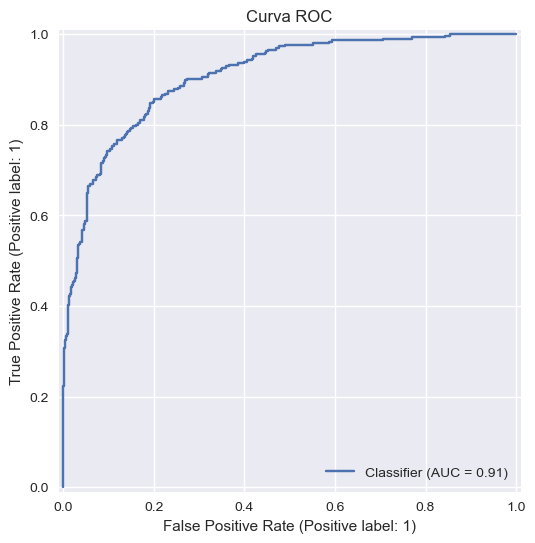

['mejor_modelo_logreg.pkl']

In [26]:
# Obtener las predicciones en los datos de prueba
y_pred = grid_search.predict(X_test)

# Opcional: Probabilidades de predicción (para umbrales personalizados)
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]  # Probabilidad de clase positiva

# Mostrar métricas de evaluación básicas
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print(f"\nExactitud (Accuracy): {accuracy_score(y_test, y_pred):.4f}")

# Curva ROC
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_test, y_pred_proba)
plt.title('Curva ROC')
plt.show()

# Opcional: Guardar el modelo para uso futuro
import joblib # type: ignore
joblib.dump(grid_search.best_estimator_, 'mejor_modelo_logreg.pkl')

# Modelo GradientBoostingClassifier  
*(Tipo ensemble dentro de machine learning)*

In [27]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', GradientBoostingClassifier(n_estimators=10000, validation_fraction=0.1, 
                                       n_iter_no_change=50, tol=1e-4, random_state=42))  # Cambio clave aquí
])

# Nuevos parámetros para la búsqueda en grilla
params = {
    'tfidf__max_df': [0.85, 0.95],
    'tfidf__min_df': [2, 3],
    'tfidf__max_features': [2000, 5000],
    'clf__n_estimators': [5000],       # Número de árboles
    'clf__learning_rate': [0.05],    # Tasa de aprendizaje
    'clf__max_depth': [5],               # Profundidad máxima
    'clf__min_samples_split': [2,5],          # Mínimo muestras para dividir
    'clf__min_samples_leaf': [2]            # Mínimo muestras en hojas
}

# Configurar GridSearchCV (ajustar cv según tamaño del dataset)
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=3,  # Reducir cv para mayor velocidad (usar 5 si hay suficientes datos)
    scoring='accuracy',
    n_jobs=-1,
    verbose=1  # Muestra progreso
)

# Ejecutar la búsqueda
grid_search.fit(X_train, y_train)

# Resultados
print("\nMejores parámetros:", grid_search.best_params_)
print("Mejor puntuación de validación:", grid_search.best_score_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits

Mejores parámetros: {'clf__learning_rate': 0.05, 'clf__max_depth': 5, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 5000, 'tfidf__max_df': 0.85, 'tfidf__max_features': 5000, 'tfidf__min_df': 3}
Mejor puntuación de validación: 0.7903152919496897



=== Reporte de Clasificación ===
              precision    recall  f1-score   support

           0       0.84      0.89      0.87       504
           1       0.79      0.72      0.75       296

    accuracy                           0.83       800
   macro avg       0.82      0.80      0.81       800
weighted avg       0.82      0.83      0.82       800


=== Matriz de Confusión ===
[[448  56]
 [ 83 213]]

Exactitud (Accuracy): 0.8263

AUC-ROC: 0.8987
F1-Score: 0.7540


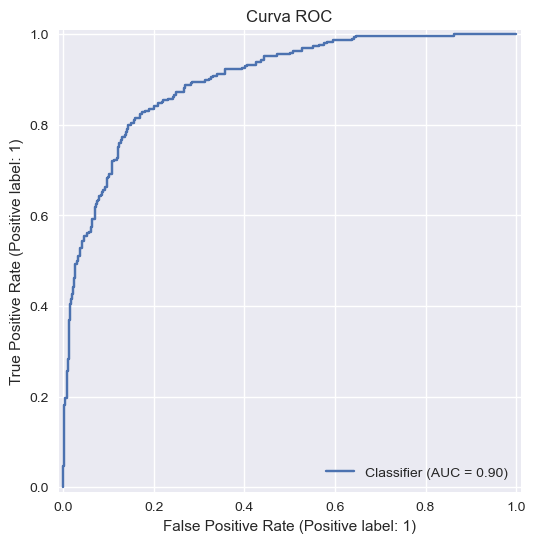

['mejor_modelo_GradBoosClass.pkl']

In [28]:
# Realizar predicciones en el conjunto de prueba
y_pred = grid_search.predict(X_test)
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva


print("\n=== Reporte de Clasificación ===")
print(classification_report(y_test, y_pred))

print("\n=== Matriz de Confusión ===")
print(confusion_matrix(y_test, y_pred))

print(f"\nExactitud (Accuracy): {accuracy_score(y_test, y_pred):.4f}")

# Opcional: Métricas adicionales para problemas binarios
from sklearn.metrics import roc_auc_score, f1_score

print(f"\nAUC-ROC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

RocCurveDisplay.from_predictions(y_test, y_pred_proba)
plt.title('Curva ROC')
plt.show()

# Guardar el modelo entrenado para uso futuro
import joblib
joblib.dump(grid_search.best_estimator_, 'mejor_modelo_GradBoosClass.pkl')

In [29]:
!pip install gensim tensorflow keras

# Arquitectura LSTM + Word2Vec  
*Word2Vec entrenado con corpus específico*  
*(Deep Learning para NLP)*

In [30]:
from gensim.models import Word2Vec
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np

In [31]:
X_train_tokenized = [review.split() for review in X_train]
w2v_model = Word2Vec(sentences=X_train_tokenized,
                     vector_size=200,  # o 300 si tienes muchos datos
                     window= 5, # Contexto de 7 palabras
                     min_count=1,
                     workers=-1)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)  # con texto plano

X_seq = tokenizer.texts_to_sequences(X_train)
vocab_size = len(tokenizer.word_index) + 1



embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))







In [32]:
X_train_tokenized = [review.split() for review in X_train]

In [33]:
w2v_model = Word2Vec(sentences=X_train_tokenized,
                     vector_size=200,  # o 300 si tienes muchos datos
                     window= 5, # Contexto de 7 palabras
                     min_count=1,
                     workers=-1)

In [34]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)  # con texto plano

X_seq = tokenizer.texts_to_sequences(X_train)
vocab_size = len(tokenizer.word_index) + 1

In [35]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

### Justificación del tamaño de padding (150 palabras)

He elegido un tamaño de padding de **150 palabras** basándome en la distribución de longitud de las reviews. Esta decisión se justifica por varios motivos:

- **Captura la mayoría de las reviews completas**, ya que muchas tienen menos de 200 palabras.
- **No es un valor excesivo**, lo que evita un uso innecesario de memoria o tiempo de entrenamiento.
- Este valor está **muy por encima de la media (87.1) y la mediana (45.0)**, lo que garantiza que no se pierda información relevante en la mayoría de los casos.
- En general, representa un **buen equilibrio entre cobertura y eficiencia**, permitiendo que el modelo trabaje con suficiente contexto sin sobrecargar el sistema.

Este tamaño es especialmente razonable para el análisis de sentimiento, donde el contenido clave suele estar en las primeras frases y no siempre se necesita todo el texto completo.

In [36]:
maxlen = 150  # Ajusta según la longitud típica de tus reseñas
X_padded = pad_sequences(X_seq, padding='post', maxlen=maxlen)

In [37]:
# Definir el modelo LSTM
model = Sequential()

# Capa de embedding pre-entrenada (no entrenable)
model.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix],
                    input_length=maxlen,
                    trainable=True))

# Spatial Dropout para regularización
model.add(SpatialDropout1D(0.2))

# Capa LSTM
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))

# Capa densa para la salida con activación sigmoide (clasificación binaria)
model.add(Dense(1, activation='sigmoid'))

# Resumen del modelo
model.summary()

/opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     4,168,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,168,200 (15.90 MB)

 Trainable params: 4,168,200 (15.90 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Compilar el modelo
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.00005),
              metrics=['accuracy'])

# Definir callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_lstm_model.h5', monitor='val_accuracy', 
                                  save_best_only=True, mode='max')

Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.6158 - loss: 0.6888

40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 397ms/step - accuracy: 0.6154 - loss: 0.6887 - val_accuracy: 0.5719 - val_loss: 0.6805
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 393ms/step - accuracy: 0.5962 - loss: 0.6753 - val_accuracy: 0.5719 - val_loss: 0.6765
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.6028 - loss: 0.6626

40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 400ms/step - accuracy: 0.6027 - loss: 0.6628 - val_accuracy: 0.5750 - val_loss: 0.6759
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.6111 - loss: 0.6680

40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 428ms/step - accuracy: 0.6111 - loss: 0.6680 - val_accuracy: 0.5875 - val_loss: 0.6751
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.6136 - loss: 0.6679

40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 416ms/step - accuracy: 0.6138 - loss: 0.6679 - val_accuracy: 0.5938 - val_loss: 0.6747
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.6231 - loss: 0.6676

40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 403ms/step - accuracy: 0.6233 - loss: 0.6675 - val_accuracy: 0.6016 - val_loss: 0.6747
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.6442 - loss: 0.6644

40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 445ms/step - accuracy: 0.6442 - loss: 0.6643 - val_accuracy: 0.6078 - val_loss: 0.6734
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.6608 - loss: 0.6608

40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 449ms/step - accuracy: 0.6608 - loss: 0.6608 - val_accuracy: 0.6141 - val_loss: 0.6725
Epoch 9/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.6651 - loss: 0.6622

40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 412ms/step - accuracy: 0.6653 - loss: 0.6621 - val_accuracy: 0.6219 - val_loss: 0.6717
Epoch 10/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.6789 - loss: 0.6598

40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 413ms/step - accuracy: 0.6789 - loss: 0.6597 - val_accuracy: 0.6266 - val_loss: 0.6703
Epoch 11/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 440ms/step - accuracy: 0.6765 - loss: 0.6561 - val_accuracy: 0.6266 - val_loss: 0.6676
Epoch 12/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 400ms/step - accuracy: 0.6923 - loss: 0.6461 - val_accuracy: 0.6250 - val_loss: 0.6634
Epoch 13/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.6902 - loss: 0.6423

40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 406ms/step - accuracy: 0.6901 - loss: 0.6422 - val_accuracy: 0.6438 - val_loss: 0.6549
Epoch 14/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.6811 - loss: 0.6293

40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 413ms/step - accuracy: 0.6813 - loss: 0.6291 - val_accuracy: 0.6562 - val_loss: 0.6295
Epoch 15/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.6921 - loss: 0.5907

40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 400ms/step - accuracy: 0.6925 - loss: 0.5908 - val_accuracy: 0.6656 - val_loss: 0.6149
Epoch 16/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.7411 - loss: 0.5474

40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 411ms/step - accuracy: 0.7412 - loss: 0.5473 - val_accuracy: 0.7219 - val_loss: 0.5666
Epoch 17/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.7833 - loss: 0.5116

40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 413ms/step - accuracy: 0.7836 - loss: 0.5113 - val_accuracy: 0.7609 - val_loss: 0.6339
Epoch 18/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 432ms/step - accuracy: 0.7856 - loss: 0.5813 - val_accuracy: 0.6594 - val_loss: 0.6745
Epoch 19/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 421ms/step - accuracy: 0.7316 - loss: 0.5702 - val_accuracy: 0.6875 - val_loss: 0.6918
Epoch 20/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 449ms/step - accuracy: 0.7822 - loss: 0.5022 - val_accuracy: 0.7125 - val_loss: 0.7003
Epoch 21/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 427ms/step - accuracy: 0.8014 - loss: 0.4842 - val_accuracy: 0.7344 - val_loss: 0.6568
Epoch 22/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 439ms/step - accuracy: 0.8252 - loss: 0.4456 - val_accuracy: 0.7203 - val_loss: 0.5924
Epoch 23/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 452ms/step - accuracy: 0.8092 - loss: 0.4506 - val_accuracy: 0.7234 - val_loss: 0.6258
Epoch 24/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.8125 - loss: 0.4543

40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 433ms/step - accuracy: 0.8129 - loss: 0.4539 - val_accuracy: 0.7734 - val_loss: 0.5944


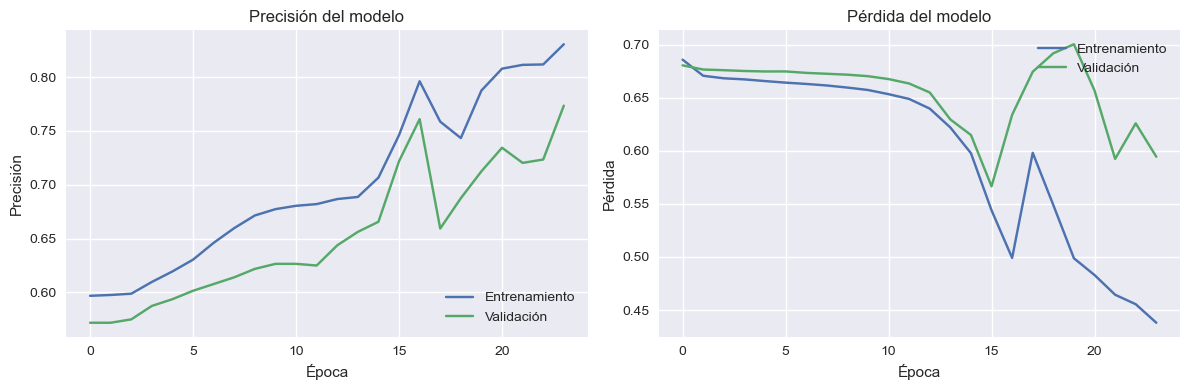

In [39]:
# Entrenar el modelo
history = model.fit(
    X_padded, y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop, model_checkpoint],
    verbose=1
)

# Visualizar el entrenamiento
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper right')

plt.tight_layout()
plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.90      0.81       504
           1       0.73      0.45      0.56       296

    accuracy                           0.74       800
   macro avg       0.73      0.68      0.69       800
weighted avg       0.74      0.74      0.72       800


=== Matriz de Confusión ===
[[455  49]
 [162 134]]


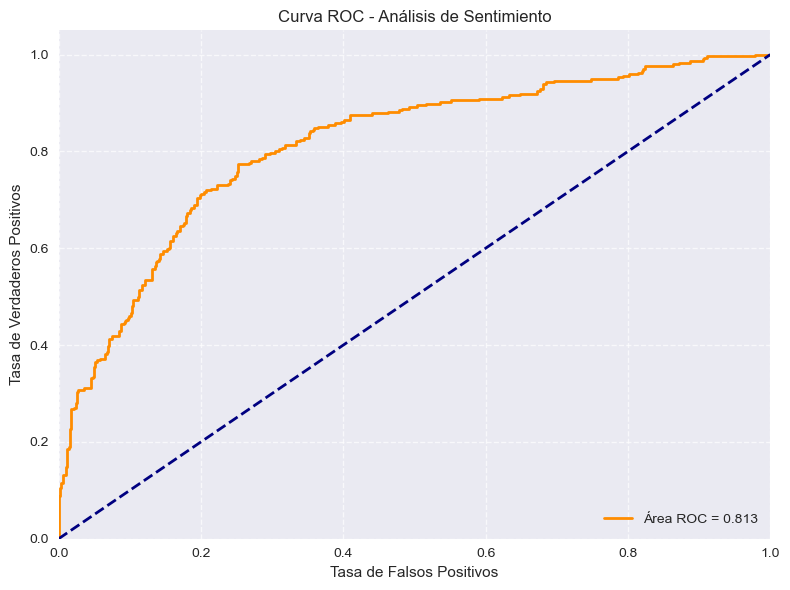

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import numpy as np

# Preparar los datos de prueba
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_seq, padding='post', maxlen=maxlen)

# Obtener predicciones
y_pred_prob = model.predict(X_test_padded)
y_pred = (y_pred_prob > 0.5).astype(int)

# 1. Classification Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# 2. Confusion Matrix
print("\n=== Matriz de Confusión ===")
print(confusion_matrix(y_test, y_pred))

# 3. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Área ROC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Análisis de Sentimiento')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



# Arquitectura LSTM + Word2Vec 
*Word2Vec preentrenado con GoogleNews-vectors-negative300*  
*(Deep Learning para NLP)*

In [41]:
# Tokenización utilizando mis datos
from tensorflow.keras.preprocessing.text import Tokenizer
from gensim.models import KeyedVectors

# Tokeniza tus textos para crear el vocabulario
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)  # <- Primera vez que usas tus datos
vocab_size = len(tokenizer.word_index) + 1
# Carga el modelo preentrenado 
w2v_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

embedding_dim = 300  # ¡Importante! Usar el valor correcto para el modelo
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in w2v_model:
        embedding_matrix[i] = w2v_model[word]
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

# Preprocesamiento final (mis datos a secuencias)
X_train_seq = tokenizer.texts_to_sequences(X_train)  # Tus textos a secuencias
maxlen = 150  # Longitud máxima (ajusta según tus datos)
X_padded = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')

In [42]:
model = Sequential()
model.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],  # ¡Aquí usas la matriz creada con Word2Vec!
    input_length=maxlen,
    trainable=False  # Congela los embeddings
))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     6,252,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,252,300 (23.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,252,300 (23.85 MB)

In [45]:
history = model.fit(
    X_padded,  # Tus secuencias
    y_train,    # Tus etiquetas
    epochs=25,
    batch_size=64,
    validation_split=0.2
)

Epoch 1/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 415ms/step - accuracy: 0.6690 - loss: 0.6221 - val_accuracy: 0.6391 - val_loss: 0.6353
Epoch 2/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 411ms/step - accuracy: 0.6872 - loss: 0.6027 - val_accuracy: 0.6328 - val_loss: 0.6466
Epoch 3/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 423ms/step - accuracy: 0.6723 - loss: 0.6119 - val_accuracy: 0.6297 - val_loss: 0.6448
Epoch 4/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 419ms/step - accuracy: 0.6772 - loss: 0.5967 - val_accuracy: 0.6422 - val_loss: 0.6399
Epoch 5/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 447ms/step - accuracy: 0.6708 - loss: 0.5895 - val_accuracy: 0.6344 - val_loss: 0.6519
Epoch 6/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 424ms/step - accuracy: 0.6823 - loss: 0.5843 - val_accuracy: 0.6375 - val_loss: 0.6495
Epoch 7/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 417ms/step - accuracy: 0.6950 - loss: 0.5654 - val_accuracy: 0.6328 - val_loss: 0.6558
Epoch 8/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 417ms/step - accuracy: 0.7000 - loss: 0.5617 - val_accu

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step

=== Classification Report ===
              precision    recall  f1-score   support

    Negativo       0.67      0.95      0.78       504
    Positivo       0.71      0.19      0.29       296

    accuracy                           0.67       800
   macro avg       0.69      0.57      0.54       800
weighted avg       0.68      0.67      0.60       800


=== Matriz de Confusión ===
[[481  23]
 [241  55]]


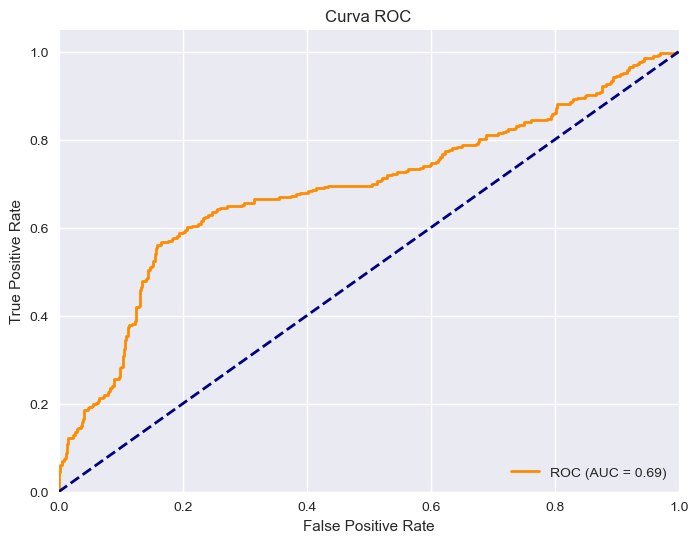

In [47]:
# Preprocesar datos de test (usando MISMO tokenizer y maxlen)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')

# Obtener predicciones (probabilidades y clases)
y_pred_proba = model.predict(X_test_padded).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)  # Umbral 0.5 para clasificación binaria
# Reporte de clasificación
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=["Negativo", "Positivo"]))
# Matriz de confusión
print("\n=== Matriz de Confusión ===")
print(confusion_matrix(y_test, y_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# 3. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


# Modelo BertForSequenceClassification de HugginFace
*(Deep Learning)*

In [48]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch

# 1. Preparar datos
train_dataset = Dataset.from_dict({'text': X_train, 'label': y_train})
eval_dataset = Dataset.from_dict({'text': X_test, 'label': y_test})  # Asume que tienes X_test, y_test

# 2. Tokenización
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_eval = eval_dataset.map(tokenize_function, batched=True)

# 3. Configuración de entrenamiento
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    evaluation_strategy='epoch',  # Evalúa al final de cada época
    save_strategy='epoch',
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
)

# 4. Inicializar modelo
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2  # Para clasificación binaria
)

# 5. Crear Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,  # Dataset de evaluación
    compute_metrics=lambda p: {'accuracy': (p.predictions.argmax(-1) == p.label_ids).mean()}  # Métrica opcional
)

# 6. Entrenar
trainer.train()

# 7. Preprocesar datos de test (si no lo hiciste antes)

tokenized_test = eval_dataset.map(tokenize_function, batched=True)

# 8. Predicciones
predictions = trainer.predict(tokenized_test)
predicted_labels = predictions.predictions.argmax(-1)

# 9. Reporte
print(classification_report(y_test, predicted_labels))

# 10. Guardar modelo para uso futuro (opcional)
trainer.save_model("mi_modelo_bert")
tokenizer.save_pretrained("mi_modelo_bert")

/opt/homebrew/anaconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/600 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 0.36503490805625916, 'eval_accuracy': 0.84125, 'eval_runtime': 8.0142, 'eval_samples_per_second': 99.823, 'eval_steps_per_second': 12.478, 'epoch': 1.0}


/opt/homebrew/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 0.3624206781387329, 'eval_accuracy': 0.86625, 'eval_runtime': 7.9291, 'eval_samples_per_second': 100.894, 'eval_steps_per_second': 12.612, 'epoch': 2.0}


/opt/homebrew/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 0.3553, 'grad_norm': 21.832021713256836, 'learning_rate': 8.333333333333334e-06, 'epoch': 2.5}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 0.5200810432434082, 'eval_accuracy': 0.8675, 'eval_runtime': 7.8748, 'eval_samples_per_second': 101.59, 'eval_steps_per_second': 12.699, 'epoch': 3.0}
{'train_runtime': 312.9094, 'train_samples_per_second': 30.68, 'train_steps_per_second': 1.917, 'train_loss': 0.3192737897237142, 'epoch': 3.0}


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/opt/homebrew/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  0%|          | 0/100 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.89      0.90      0.90       504
           1       0.83      0.80      0.82       296

    accuracy                           0.87       800
   macro avg       0.86      0.85      0.86       800
weighted avg       0.87      0.87      0.87       800



('mi_modelo_bert/tokenizer_config.json',
 'mi_modelo_bert/special_tokens_map.json',
 'mi_modelo_bert/vocab.txt',
 'mi_modelo_bert/added_tokens.json')

# Conclusiones

De todos los modelos que has probado, **BERT** es el que claramente ofrece el mejor rendimiento. No solo alcanza la mayor **precisión global (87%)**, sino que también logra un buen equilibrio entre *precisión* y *recall* en ambas clases, especialmente en la positiva, que suele ser más difícil de predecir. 

En contraste, los modelos **LSTM** —incluso usando **Word2Vec preentrenado**— muestran serios problemas para identificar correctamente las reseñas positivas, con un *recall* muy bajo. 

Los modelos clásicos como **Logistic Regression** y **Gradient Boosting** se defienden bastante bien y serían una buena alternativa si buscas algo más ligero o más fácil de explicar, pero no alcanzan el nivel de BERT. 

En resumen, si lo que buscas es el mejor rendimiento posible y cuentas con los recursos, **BERT es claramente la mejor opción**.